In [1]:
pip install -U sentence-transformers cleanlab hdbscan umap umap-learn[plot] wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 KB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 42.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.3 MB/s eta 0:00:00
  Pre

In [18]:
# IMPORTS

from cleanlab.outlier import OutOfDistribution
from enum import Enum
from google.colab import files
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from PIL import Image
from sentence_transformers import SentenceTransformer
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, ENGLISH_STOP_WORDS
from sklearn.metrics import adjusted_mutual_info_score, adjusted_rand_score, silhouette_score
from sklearn.preprocessing import StandardScaler
from transformers import AutoTokenizer, AutoModel
from umap.umap_ import INT32_MAX
from wordcloud import WordCloud
from yellowbrick.cluster import SilhouetteVisualizer

import cleanlab
import gzip
import hdbscan
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
import sklearn.cluster as cluster
import string
import torch
import torch.nn.functional as F
import umap
import unicodedata

from wordcloud import STOPWORDS
from nltk.stem import WordNetLemmatizer
from statistics import mean
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [7]:
# Constants
URL = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/presidential_speeches.csv"
stop_words = set(stopwords.words('english')) # switched to sklearn as it is larger than nltk stopwords
dataset = pd.read_csv(URL)
p = 0.65 #increase p = no of segments decreases

# Initialization
SEPERATE_BY_PRES = False

# Pre-Processing
MIN_SENTENCE_WORDS = 5
PLOT_SPEECHLEN_HIST = True
MIN_SPEECH_SENTENCE_COUNT = 10 # 10 sentences needed for cleanlab embedding

# Cleanlab
LOAD_FROM_CSV = True
EMBEDDING_CSV_DIRECTORY = 'Data_Output/ModernPresidents'
EMBEDDING_LOAD_BASE_URL = 'https://github.com/yahya010/DocClustering/blob/main/Code/Data_Output/ModernPresidents/'
OUTLIER_SCORE_CUTOFF = 0.5
PRINT_CLEANLAB_ANALYSIS = True

# KMeans
CLUSTER_RANGE = range(2, 51)

# Create data output directory if needed
if not os.path.exists('Data_Output'):
   # Create a new directory because it does not exist
   os.makedirs('Data_Output')


## REF: https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nlp_tf-idf_clustering.ipynb#scrollTo=EbAMAIFFV_xh

# List of Presidents
class PresidentIndex(Enum):
  George_Washington = 0
  John_Adams = 1
  Thomas_Jefferson = 2
  James_Madison = 3
  James_Monroe = 4
  John_Quincy_Adams = 5
  Andrew_Jackson = 6
  Martin_Van_Buren = 7
  William_Harrison = 8
  John_Tyler = 9
  James_Polk = 10
  Zachary_Taylor = 11
  Millard_Fillmore = 12
  Franklin_Pierce = 13
  James_Buchanan = 14
  Abraham_Lincoln = 15
  Andrew_Johnson = 16
  Ulysses_Grant = 17
  Rutherford_Hayes = 18
  James_Garfield = 19
  Chester_Arthur = 20
  Grover_Cleveland_1 = 21
  Benjamin_Harrison = 22
  Grover_Cleveland_2 = 23
  William_McKinley = 24
  Theodore_Roosevelt = 25
  William_Taft = 26
  Woodrow_Wilson = 27
  Warren_Harding = 28
  Calvin_Coolidge = 29
  Herbert_Hoover = 30
  Franklin_Roosevelt = 31
  Harry_Truman = 32
  Dwight_Eisenhower = 33 
  John_Kennedy= 34
  Lyndon_Johnson = 35
  Richard_Nixon = 36
  Gerald_Ford = 37
  James_Carter = 38
  Ronald_Reagan = 39
  George_Bush_SR = 40
  William_Clinton = 41
  George_Bush = 42
  Barack_Obama = 43
  Donald_Trump = 44

# Set Presidents to use
PRESIDENTS = [PresidentIndex.Ronald_Reagan, PresidentIndex.George_Bush_SR, PresidentIndex.William_Clinton, PresidentIndex.George_Bush, PresidentIndex.Barack_Obama, PresidentIndex.Donald_Trump];
PRESIDENT_NAMES = [n.name for n in PRESIDENTS]

# Get stopwords, stemmer and lemmatizer
stemmer = nltk.stem.PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()
general_stopwords = ENGLISH_STOP_WORDS  # note: sklearn has a longer list than nltk.corpus.stopwords.words('english')
additional_stopwords = []


# Get data samples and associated president
speeches = []
speech_classes = []

## TODO: VERIFY ALL PRES NAMES MATCH
# Tested: Washington, Lincoln

for index, row in dataset.iterrows():
  underscoreName = row['President'].replace(' ', '_')
  
  if underscoreName in PRESIDENT_NAMES:
    speeches.append(row['Transcript'])
    speech_classes.append(PresidentIndex[underscoreName].value)


In [ ]:
def z_score(data):
    """Calculates the z-scores for a given dataset."""
    mean = np.mean(data)
    std_dev = np.std(data)
    z_scores = (data - mean) / std_dev
    return z_scores

In [ ]:
# Running Cleanlab WITH z score removal
# Filters unrelated sentences from each individual speech

# Filtered speeches = list of every useful sentence across every speech of the selected president(s)
post_cleanlab_speeches = []
post_cleanlab_sentences = []
post_cleanlab_speeches_z_score = []
post_cleanlab_sentences_z_score = []

all_cleanlab_scores = []
all_z_scores = []

# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

filtered_sent_percentages = []
filtered_sent_percentages_z_score = []

for i, speech in enumerate(pre_processed_speeches):
  try:
    ood = OutOfDistribution()
    original_embeddings = model.encode(speech)
    train_outlier_scores = ood.fit_score(features=original_embeddings)
    # get outlier id's for sentences with outlier scores below cutoff value
    outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]
    # find z score for sentences and set z score cuttoff to determine what to remove
    z_scores = z_score(train_outlier_scores)
    outlier_ids_z_score = [i for i, outlier_score_z_score in enumerate(z_scores) if  outlier_score_z_score < Z_SCORE_CUTOFF]

    if PRINT_CLEANLAB_ANALYSIS:
      filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
      filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
      filtered_sent_percentages.append(filtered_percent)
       # z score filtered removal number
      filtered_sentences_z_score = [s for i, s in enumerate(speech) if i in outlier_ids_z_score]
      filtered_percent_z_score = round((len(filtered_sentences_z_score) / len(speech)) * 100) 
      filtered_sent_percentages_z_score.append(filtered_percent_z_score)

      # Metrics
      
      average_cleanlab_score = float(np.mean(train_outlier_scores))
      variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in train_outlier_scores) / (len(train_outlier_scores) - 1))
      std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
      min_cleanlab_score = float(min(train_outlier_scores))
      max_cleanlab_score = float(max(train_outlier_scores))
      average_z_score = float(np.mean(z_scores))
      variance_z_score = float(sum((x - average_z_score)**2 for x in z_scores) / (len(z_scores) - 1))
      std_z_score = float(np.sqrt(variance_z_score))
      min_z_score = float(min(z_scores))
      max_z_score = float(max(z_scores))

      all_cleanlab_scores.extend(train_outlier_scores)
      all_z_scores.extend(z_scores)
      
      print(f'Speech: {i}')
      print("Cleanlab Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_cleanlab_score, 3)}')
      print(f'  Variance: {round(variance_cleanlab_score, 3)}')
      print(f'  STDev: {round(std_cleanlab_score, 3)}')
      print(f'  Min: {round(min_cleanlab_score, 3)}')
      print(f'  Max: {round(max_cleanlab_score, 3)}')
      print("Cleanlab with Z Score Metrics:")
      print(f'  Percent Sentences Filtered: {filtered_percent_z_score}% out of {len(speech)} Sentences')
      print(f'  Average: {round(average_z_score, 3)}')
      print(f'  Variance: {round(variance_z_score, 3)}')
      print(f'  STDev: {round(std_z_score, 3)}')
      print(f'  Min: {round(min_z_score, 3)}')
      print(f'  Max: {round(max_z_score, 3)}')
      print("Filtered Sentences:")
      for i, s in enumerate(filtered_sentences):
        print(f'  {i}: {s}')
      print("Filtered Sentences Z score:")
      for i, s in enumerate(filtered_sentences_z_score):
        print(f'  {i}: {s}')
      print("\n\n")

    speech_cleanlab = [s for i, s in enumerate(speech) if i not in outlier_ids]
    speech_z_score = [s for i, s in enumerate(speech) if i not in outlier_ids_z_score]

    post_cleanlab_speeches.append(speech_cleanlab)
    post_cleanlab_speeches_z_score.append(speech_z_score)

    for sentence in speech_cleanlab:
      post_cleanlab_sentences.append(sentence)
    for sentence in speech_z_score:
      post_cleanlab_speeches_z_score.append(sentence)
  except:
    continue

print(f'Cleanlab score: {all_cleanlab_scores}')
print(f'Z score: {all_z_scores}')

# Z score is currently being removed from the threshold found from each speech meaning the same percentage of lowest ranking scores are cut from every speech not matter the context. 
# We need to either combine the loop to go through them all at once and remove that percentage from the corpus or remover CL score thresholds from individual speeches.

# filtered_speech_embeddings = model.encode(post_cleanlab_sentences) # embedding
# filtered_speech_embeddings_z_score = model.encode(post_cleanlab_speeches_z_score)

# if PRINT_CLEANLAB_ANALYSIS:
#   # print(f'Unfiltered Speech Shape: {model.encode(pre_processed_speeches).shape}') vcc
#   print(f'Filtered Speech Shape: {filtered_speech_embeddings.shape}')
#   print(f'Filtered Speech Shape Z Score: {filtered_speech_embeddings_z_score.shape}')
#   print(f'Average percentage of filtered sentences per speech (cutoff value  of {OUTLIER_SCORE_CUTOFF}): {sum(filtered_sent_percentages) / len(filtered_sent_percentages)}')
#   print(f'Average percentage of filtered z score sentences per speech (cutoff value  of {Z_SCORE_CUTOFF}): {sum(filtered_sent_percentages_z_score) 

In [ ]:
average_cleanlab_score = float(np.mean(all_cleanlab_scores))
variance_cleanlab_score = float(sum((x - average_cleanlab_score)**2 for x in all_cleanlab_scores) / (len(all_cleanlab_scores) - 1))
std_cleanlab_score = float(np.sqrt(variance_cleanlab_score))
min_cleanlab_score = float(min(all_cleanlab_scores))
max_cleanlab_score = float(max(all_cleanlab_scores))
average_z_score = float(np.mean(all_z_scores))
variance_z_score = float(sum((x - average_z_score)**2 for x in all_z_scores) / (len(all_z_scores) - 1))
std_z_score = float(np.sqrt(variance_z_score))
min_z_score = float(min(all_z_scores))
max_z_score = float(max(all_z_scores))
print("Cleanlab Metrics:")
print(f'  Average: {round(average_cleanlab_score, 3)}')
print(f'  Variance: {round(variance_cleanlab_score, 3)}')
print(f'  STDev: {round(std_cleanlab_score, 3)}')
print(f'  Min: {round(min_cleanlab_score, 3)}')
print(f'  Max: {round(max_cleanlab_score, 3)}')
print("Cleanlab with Z Score Metrics:")
print(f'  Average: {round(average_z_score, 3)}')
print(f'  Variance: {round(variance_z_score, 3)}')
print(f'  STDev: {round(std_z_score, 3)}')
print(f'  Min: {round(min_z_score, 3)}')
print(f'  Max: {round(max_z_score, 3)}')

In [ ]:
# Cleanlab and Z score Histogram
cleanlab_histogram_cutoff = 0.5
num_bins = 50

# Cleanlab Histogram
fig = plt.figure(figsize=(28, 5))
n, bins, patches = plt.hist(all_cleanlab_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_cleanlab_scores)
count = len([x for x in sorted_data if x < cleanlab_histogram_cutoff])
# val = np.min(sorted_data[n_smallest_num - 1])
idx = np.searchsorted(bins, cleanlab_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
plt.xlabel('Cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Cleanlab Score Data')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
             int(n[i]), ha='center', va='bottom')
plt.show()

# Cleanlab with Z Score Histogram
fig = plt.figure(figsize=(28, 5))
n, bins, patches = plt.hist(all_z_scores, bins=num_bins, color='blue', alpha=0.8) # alpha is transparency of bars
sorted_data = np.sort(all_z_scores)
z_score_histogram_cutoff = np.min(sorted_data[count - 1])
z_score_count = len([x for x in sorted_data if x < z_score_histogram_cutoff])
idx = np.searchsorted(bins, z_score_histogram_cutoff, side='left')
x = bins[idx]
plt.axvline(x=x, color='red', linestyle='--')
plt.xlabel('Z score of cleanlab score')
plt.ylabel('Frequency')
plt.title('Histogram of Z Score of Cleanlab Data')
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width()/2.0, patches[i].get_height(),
             int(n[i]), ha='center', va='bottom')
plt.show()
print(f'Cleanlab')
print(f'  Smallest Cleanlab Number Score: {cleanlab_histogram_cutoff}')
print(f'  Percent Filtered Out: {round(float((count/len(all_cleanlab_scores))*100),2)}%')

print(f'Z Score')
print(f'  Smallest Z Score Number Score: {round(float(z_score_histogram_cutoff),3)}')
print(f'  Percent Filtered Out: {round(float((z_score_count/len(all_z_scores))*100),2)}%')

Number of Speeches Processed: 128
Filtered 0 speeches (under 10 sentences in total length)


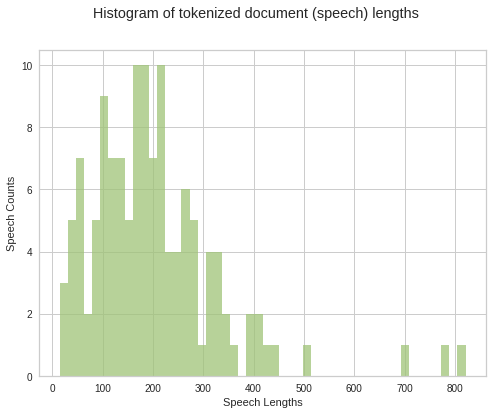

In [4]:
# Pre-Processing

pre_processed_speeches = []
list_token_lists = []


exclude = string.punctuation.replace(".", "")
exclude = exclude.replace("!", "")
exclude = exclude.replace("?", "")

# Pre-Processing Helpers
def remove_accents(data):
    return ''.join(x for x in unicodedata.normalize('NFKD', data) if x in string.ascii_letters or x == " ")
  
def remove_misc(data):
  return data.replace('\n', '')

stop_words = set(stopwords.words('english'))
speech_lengths = []

for i, speech in enumerate(speeches):

  # Tokenize by sentence, then by lowercase word
  sent_count = 0
  pre_processed_speech_sentences = []

  for sentence in nltk.sent_tokenize(speech):
    token_list = []
    
    if len(nltk.word_tokenize(sentence)) < MIN_SENTENCE_WORDS:
      continue

    tokens = []
    sent_count += 1

    for word in nltk.word_tokenize(sentence):
      t = word.lower()
      t = remove_accents(t)
      t = remove_misc(t)
      t = str(t).translate(string.punctuation)
      t = t.translate(str.maketrans('', '', exclude))

      token_list.append(t)

    pre_processed_speech_sentences.append(' '.join(token_list))
  
  if sent_count >= MIN_SPEECH_SENTENCE_COUNT:
    speech_lengths.append(sent_count)
    pre_processed_speeches.append(pre_processed_speech_sentences)
  
print(f'Number of Speeches Processed: {len(pre_processed_speeches)}')
print(f'Filtered {len(speeches) - len(pre_processed_speeches)} speeches (under 10 sentences in total length)')

df_speeches = pd.DataFrame(list_token_lists)

# Plot histogram of tokenized document lengths
if PLOT_SPEECHLEN_HIST:
  fig = plt.figure(figsize=(8,6))
  plt.suptitle("Histogram of tokenized document (speech) lengths")
  plt.xlabel("Speech Lengths")
  plt.ylabel("Speech Counts")
  n, bins, patches = plt.hist(speech_lengths, bins=50, density=False, facecolor='g', alpha=0.75)
  plt.show()

In [ ]:
post_cleanlab_sentences = []
post_cleanlab_speeches = []

if LOAD_FROM_CSV:
  print("Loading Cleanlab Sentences")
  post_cleanlab_sentences = pd.read_csv(EMBEDDING_CSV_DIRECTORY + '', compression='gzip').values().tolist()

  print("Loading Cleanlab Speeches")
  post_cleanlab_speeches = pd.read_csv(EMBEDDING_CSV_DIRECTORY + '', compression='gzip').values().tolist()

  print("Loading Speech Embeddings")
  filtered_speech_embeddings = pd.read_csv(EMBEDDING_CSV_DIRECTORY + '', compression='gzip')

  print("Loading PCA Reduced Embeddings")
  reduced_embedding = pd.read_csv(EMBEDDING_CSV_DIRECTORY + '', compression='gzip')

  print("Loading UMAP Reduced Embeddings")
  sentences_embeddings_reduced = pd.read_csv(EMBEDDING_CSV_DIRECTORY + '', compression='gzip')


In [13]:
# Running Cleanlab 
# Filters unrelated sentences from each individual speech

post_cleanlab_sentences = []
post_cleanlab_speeches = []


if LOAD_FROM_CSV:
  print("Loading Cleanlab Sentences")
  post_cleanlab_sentences = pd.read_csv(EMBEDDING_LOAD_BASE_URL + 'PostCleanlabSentences.csv.gz?raw=true', compression='gzip')
  print(post_cleanlab_sentences.values[0])

  print("Loading Cleanlab Speeches")
  post_cleanlab_speeches = pd.read_csv(EMBEDDING_LOAD_BASE_URL + 'PostCleanlabSpeeches.csv.gz?raw=true', compression='gzip')
  print(post_cleanlab_speeches.values[0])

  print("Loading Speech Embeddings")
  filtered_speech_embeddings = pd.read_csv(EMBEDDING_LOAD_BASE_URL + 'SentenceEmbeddings.csv.gz?raw=true', compression='gzip')
  print(filtered_speech_embeddings.values[0])

  print("Loading PCA Reduced Embeddings")
  reduced_embedding = pd.read_csv(EMBEDDING_LOAD_BASE_URL + 'PCA_Embedding.csv.gz?raw=true', compression='gzip')
  print(reduced_embedding.values[0])

  print("Loading UMAP Reduced Embeddings")
  sentences_embeddings_reduced = pd.read_csv(EMBEDDING_LOAD_BASE_URL + 'UMAP_Embedding.csv.gz?raw=true', compression='gzip')
  print(sentences_embeddings_reduced.values[0])

else:
  # Filtered speeches = list of every useful sentence across every speech of the selected president(s)
  # Embedding and outlier removal
  model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

  filtered_sent_percentages = []

  for speech in pre_processed_speeches:
    try:
      ood = OutOfDistribution()
      original_embeddings = model.encode(speech)
      train_outlier_scores = ood.fit_score(features=original_embeddings)
      # get outlier id's for sentences with outlier scores below cutoff value
      outlier_ids = [i for i, outlier_score in enumerate(train_outlier_scores) if outlier_score < OUTLIER_SCORE_CUTOFF]
      
      if PRINT_CLEANLAB_ANALYSIS:
        filtered_sentences = [s for i, s in enumerate(speech) if i in outlier_ids]
        filtered_percent = round((len(filtered_sentences) / len(speech)) * 100) 
        filtered_sent_percentages.append(filtered_percent)


        print(f'Percentage of Sentences Filtered: {filtered_percent}')
        print("Filtered Sentences:")
        for s in filtered_sentences:
          print(f'{s}')
        print("\n\n")

      speech = [s for i, s in enumerate(speech) if i not in outlier_ids]

      post_cleanlab_speeches.append(speech)
      for sentence in speech:
        post_cleanlab_sentences.append(sentence)
    except:
      continue
    


  filtered_speech_embeddings = model.encode(post_cleanlab_sentences)

  if PRINT_CLEANLAB_ANALYSIS:
    print(f'Unfiltered Speech Shape: {model.encode(pre_processed_speeches).shape}')
    print(f'Filtered Speech Shape: {filtered_speech_embeddings.shape}')

    print(f'Average percentage of filtered sentences per speech (cutoff value  of {OUTLIER_SCORE_CUTOFF}): {sum(filtered_sent_percentages) / len(filtered_sent_percentages)}')

Loading Cleanlab Sentences
[0
 'as a matter of fact  i have been permitted to choose my own words and discuss my own ideas regarding the choice that we face in the next few weeks ']
Loading Cleanlab Speeches
[0
 'as a matter of fact  i have been permitted to choose my own words and discuss my own ideas regarding the choice that we face in the next few weeks '
 'i have spent most of my life as a democrat '
 'i believe that the issues confronting us cross party lines '
 'now  one side in this campaign has been telling us that the issues of this election are the maintenance of peace and prosperity '
 'the line has been used   we ve never had it so good  but i have an uncomfortable feeling that this prosperity is nt something on which we can base our hopes for the future '
 'no nation in history has ever survived a tax burden that reached a third of its national income '
 'today   cents out of every dollar earned in this country is the tax collector s share  and yet our government continue

In [ ]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform([f for f in filtered_speech_embeddings])
print(reduced_embedding.shape)

(24027, 333)


In [ ]:
# PCA-95 Dimensionality Reduction of Z-Score Filtered
# pca = PCA(n_components=0.95)
# reduced_embedding = pca.fit_transform([f for f in filtered_speech_embeddings_z_score])
# print(reduced_embedding.shape)

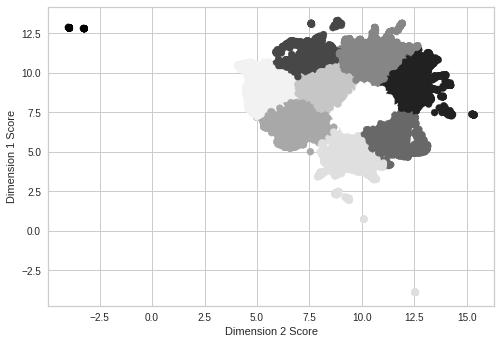

In [ ]:
# UMAP Clustering
reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(reduced_embedding)

# Apply KMeans clustering to the reduced embeddings
kmeans = KMeans(n_clusters=21)
kmeans.fit(reduced_embedding)

# Get the cluster labels for each sentence and plot
labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_
plt.figure(figsize=(12, 6))
plt.title("Cluster Map: Cleanlab Filtered")
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels, cmap='jet', s=8) # s = dot size, cmap variables include cmap = 'jet', 'viridis', 'plasma', 'inferno', 'magma', 'cividis'
# plt.xlim(6,14)  # Limits x axis range
# plt.ylim(0,10)  # Limits y axis range
plt.show()

# Does the two dimensions just represent the visual cluster comparison? KMeans is nonlinear

print(reduced_embedding.shape)


In [ ]:
# Create data output directory if needed
export_dir = 'Data_Output/ModernPresidents'
if not os.path.exists(export_dir):
   # Create a new directory because it does not exist
   os.makedirs(export_dir)

def exp_to_gzip_csv(data, path):
  speech_embedding_df = pd.DataFrame(data)
  speech_embedding_df.to_csv(path, compression='gzip')

exp_to_gzip_csv(filtered_speech_embeddings, export_dir + '/SentenceEmbeddings.csv.gz')
exp_to_gzip_csv(post_cleanlab_speeches, export_dir + '/PostCleanlabSpeeches.csv.gz')
exp_to_gzip_csv(post_cleanlab_sentences, export_dir + '/PostCleanlabSentences.csv.gz')
exp_to_gzip_csv(reduced_embedding, export_dir + '/PCA_Embedding.csv.gz')
exp_to_gzip_csv(sentences_embeddings_reduced, export_dir + '/UMAP_Embedding.csv.gz')

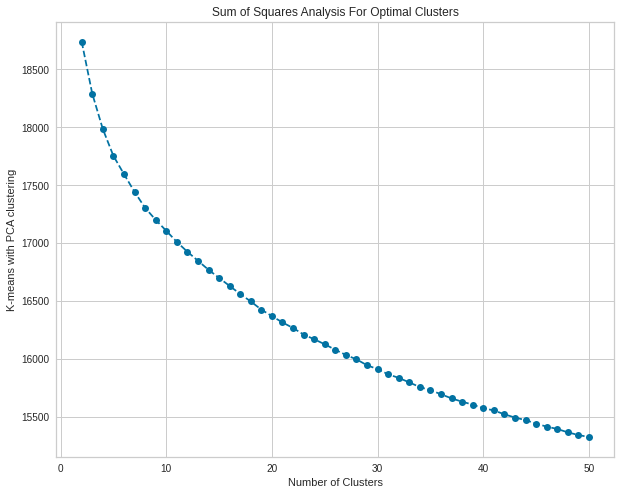

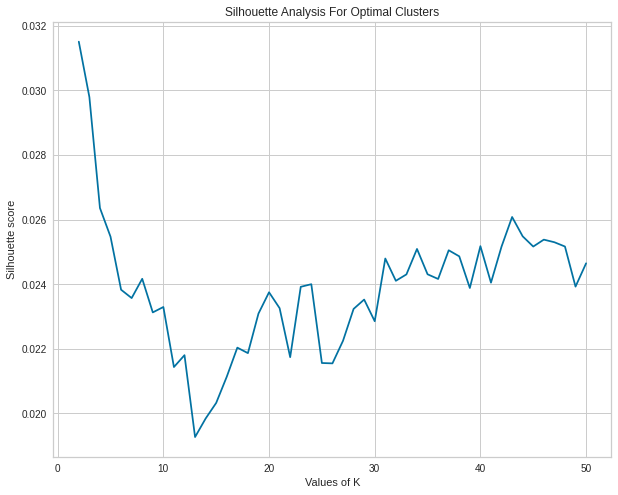

In [ ]:
# Uses two metrics (sum of squares and silhouette score) to assist in determining optimal cluster size

def kmeans_optimal_clusters(reduced_embedding, fullTranscripts, cluster_range):

    # Comparison of Within Cluster Sum of Squares (wcss) for different cluster sizes
    wcss = []
    silhouette_avg = []


    for i in cluster_range:
        km = KMeans(n_clusters=i, init='k-means++', random_state=42, n_init=10)
        km.fit(reduced_embedding)
        wcss.append(km.inertia_)
        silhouette_avg.append(silhouette_score(reduced_embedding, km.labels_, metric='euclidean', random_state=42))

    # Sum of Squares Plot
    plt.figure(figsize=(10, 8))
    plt.plot(cluster_range, wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('K-means with PCA clustering')
    plt.title('Sum of Squares Analysis For Optimal Clusters')
    plt.show()


    # Silhouette Plot
    plt.figure(figsize=(10, 8))
    plt.plot(cluster_range, silhouette_avg, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette Analysis For Optimal Clusters')
    plt.show()


kmeans_optimal_clusters(reduced_embedding, post_cleanlab_speeches, CLUSTER_RANGE)

In [ ]:
# Segmentation
segmentation  = get_optimal_splits(embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(filteredTranscript, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [ ]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


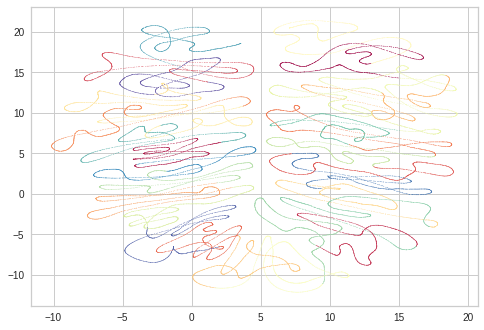

In [16]:
kmeans_labels = cluster.KMeans(n_clusters=30).fit_predict(reduced_embedding)
standard_embedding = umap.UMAP(random_state=42).fit_transform(reduced_embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

In [ ]:
def color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

In [ ]:
clusterStrings = [
                     'Text1 in this cluster1. Text2 in this cluster1. Text3 in this cluter1 hello there please tell me calculate math',
                     'Text1 in this cluster2. Text2 in this cluster2. Text3 in this cluter2 I ill can go eat run play embedding',
                     'Text1 in this cluster3. Text2 in this cluster3. Text3 in this cluster3 swim program gym drink juice words string download',
                     ]



if 'result' in globals():
  print('yes')
else:

  # Download GloVe embeddings
  
  glove_input_file = '/content/glove.6B.300d.txt'
  word2vec_output_file = '/content/word2vec.txt'
  # The first step is to convert the GloVe file format to the word2vec file format. 
  # The only difference is the addition of a small header line. This can be done by calling the 
  # glove2word2vec() function.

  #glove2word2vec(glove_input_file, word2vec_output_file)
  model = KeyedVectors.load_word2vec_format(word2vec_output_file, binary=False)
  # calculate: (king - man) + woman = ?
  result = model.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)
  print(result)


# Get the final coherence scores for each cluster

def calcFinalScores(coherenceScores, finalWeights):
  listScores = []
  for i in range(len(coherenceScores)):
    sum = 0
    for j in range(len(coherenceScores[i])):
      sum += finalWeights[i][j]*coherenceScores[i][j]
    listScores.append((sum*1000) / 45) # Multiply sum by 1000 to make scores more readable (this can be changed). Divide by 45 to get average. 
  return listScores


# Use temporary weights to get final weights. The weights will be finalized by normalizing them.

def calcFinalWeights(pairWeights):
  finalWeights = []
  for i in range(len(pairWeights)):
    curWeights = pairWeights[i]
    sumWeights = 0
    for j in range(len(curWeights)):
      # sumWeights = sumWeights + math.exp(curWeights[j])
      sumWeights = sumWeights + curWeights[j]
    tempFinalWeights = []
    for j in range(len(curWeights)):
      # tempFinalWeights.append(math.exp(curWeights[j]) / sumWeights)
      tempFinalWeights.append(curWeights[j] / sumWeights) # Normalize the weights
    finalWeights.append(tempFinalWeights)
  # sum = 0
  # for i in range(len(finalWeights[0])):
  #   sum = sum + finalWeights[1][i]
 
  return finalWeights

# This calculates the coherence score of each cluster
# The coherence is calculated by finding the pair-wise similarity between the top 10 words in the cluster.
# The top 10 words are determined using TF-IDF
# Final output will include intermediate scores and weights for the scores.
# Weigting is based on Zipf rank
#------

def calcCoherence1(clusterStrings):
  corpus = clusterStrings # set corpus as the list of clusters with corresponding texts as strings
  #corpus = [' '.join(cluster) for cluster in clusterStrings]
  # Use TF-IDF
  vectorizer = TfidfVectorizer(stop_words=list(STOPWORDS), norm=None, smooth_idf=False) 
  X = vectorizer.fit_transform(corpus)
  idf = vectorizer.idf_
  idf = idf - 1
  countVectorizer = CountVectorizer(stop_words=list(STOPWORDS))
  tf = countVectorizer.fit_transform(corpus)
  tf = tf.toarray()
  tfidf = tf*idf

  lemmatizer = WordNetLemmatizer()
  coherenceScores = []
  pairWeights = []

  for i in range(len(clusterStrings)): # loop through all clusters

    df = pd.DataFrame(tfidf[i], index=vectorizer.get_feature_names_out(), columns=["TF-IDF"])
    dfs = df.sort_values('TF-IDF', ascending=False) 

    curList = dfs.index.to_list()
    curListLem = []
    curList10 = []

    # Get top 10 words (lemmatized)
    w = 0
    c = 0
    while c < 10:
      word = curList[w]
      curWord = lemmatizer.lemmatize(word)
      if curWord not in curListLem and curWord in model.vocab:
        curListLem.append(curWord)
        c = c + 1
      w = w + 1

    # Get pair-wise scores
    tempScore = []
    tempPairWeights = []
    for a in range(len(curListLem)):
      for b in range(a, len(curListLem)):
        if a != b:
          w1 = curListLem[a]
          w2 = curListLem[b]
          weight1 = list(model.vocab.keys()).index(w1) # Get Zipf rank of word 1
          weight2 = list(model.vocab.keys()).index(w2) # Get Zipf rank of word 2
          tempPairWeights.append(mean([weight1, weight2]))
          # tempPairWeigts.append(math.log(weight1, 10) + math.log(weight2, 10) / 2)
          tempScore.append(model.similarity(w1, w2))
    pairWeights.append(tempPairWeights)
    coherenceScores.append(tempScore)
  return [pairWeights, coherenceScores] # return list of weights and temporary scores
# wrapper function to calculate coherence scores

def calcCoherence(clusterStrings):
  pairWeights_and_coherenceScores1 = calcCoherence1(clusterStrings)
  pairWeights = pairWeights_and_coherenceScores1[0]
  coherenceScores1 = pairWeights_and_coherenceScores1[1]
  finalWeights = calcFinalWeights(pairWeights)
  finalScores = calcFinalScores(coherenceScores1, finalWeights)
  return finalScores

In [15]:
#Original method - probably using this

# Your list of tokenized sentences

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(post_cleanlab_sentences)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

# Print the 50 words with the lowest tf-idf scores
# print("50 words with the lowest tf-idf scores:")
# print(sorted_words[:50])
lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

#print(len(filteredTranscript))
#low_tfidf = lowest_tfidf_words(filteredTranscript)
#print(len(lowest_tfidf_words(filteredTranscript)))
mask = np.array(Image.open('gw.png'))

for i in range(kmeans.n_clusters):
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [post_cleanlab_sentences[index] for index in cluster_indices]

    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words])
    # Generate a word cloud from the cluster text


    wordcloud = WordCloud(min_font_size=4, 
                          mask=mask,
                          width=mask.shape[1],
                          height=mask.shape[0],
                          stopwords=lowest_tfidf_words, 
                          background_color="white",
                          contour_width=1,
                          contour_color="black")
    wordcloud.generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

['unnamed']


NameError: ignored

In [ ]:
# PrePCA Cosine Similarity Matrix
heatmap = np.zeros(shape=(len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    sent = embeddings[i]
    for j in range(len(embeddings)):
        sent2 = embeddings[j]
        cosSim = cos_similarity(sent, sent2)
        heatmap[i,j] = cosSim

In [ ]:
# PostPCA Cosine Similarity Matrix (Sentence Similarity Matrix)
heatmapPost = np.zeros(shape=(len(reduced_embedding), len(reduced_embedding)))
for i in range(len(reduced_embedding)):
    sentPost = reduced_embedding[i]
    for j in range(len(reduced_embedding)):
        sent2Post = reduced_embedding[j]
        cosSimPost = cos_similarity(sentPost, sent2Post)
        heatmapPost[i,j] = cosSimPost

[[1.    0.382 0.445 ... 0.284 0.194 0.26 ]
 [0.382 1.    0.519 ... 0.33  0.208 0.306]
 [0.445 0.519 1.    ... 0.406 0.348 0.261]
 ...
 [0.284 0.33  0.406 ... 1.    0.234 0.334]
 [0.194 0.208 0.348 ... 0.234 1.    0.207]
 [0.26  0.306 0.261 ... 0.334 0.207 1.   ]]
done with PrePCA heatmap


In [ ]:
# Prenormalized Heatmaps

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCA[i,j] = heatmap[i,j]
data = heatmapPrePCA
plt.imshow( data , cmap = 'inferno' , vmax = .7, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCA[i,j] = heatmapPost[i,j]
data = heatmapPostPCA
plt.imshow( data , cmap = 'inferno' , vmax = .35, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Standardize the Data


heatmapStandard = StandardScaler().fit_transform(heatmap)
heatmapPostStandard = StandardScaler().fit_transform(heatmapPost)

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCAStandard[i,j] = heatmapStandard[i,j]
data = heatmapPrePCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCAStandard[i,j] = heatmapPostStandard[i,j]
data = heatmapPostPCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Normalized Heatmaps

# Normalize Pre and Post Cosine Similarity Matrixs
heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)
# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCANorm[i,j] = heatmapPreNorm[i,j]
data = heatmapPrePCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.6, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCANorm[i,j] = heatmapPostNorm[i,j]
data = heatmapPostPCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.5, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
plt.show()

In [ ]:
# Test Code

fullTranscripts = pd.DataFrame(fullTranscripts)
fullTranscripts.to_csv('fullTranscripts.csv')

embedding = pd.DataFrame(embedding)
embedding.to_csv('embedding.csv')

reduced_embedding = pd.DataFrame(reduced_embedding)
reduced_embedding.to_csv('reduced_embedding.csv')